# PyBaMM SPMe Parameter Identification — LS, PSO, DE

**Goal.** Identify SPMe parameters by fitting simulated terminal voltage to measured data under a constant‑current Discharge→Charge experiment.

---

## 📊 Comparison Table (LS vs PSO vs DE)

| Feature                         | Least Squares (LS)                          | Particle Swarm Optimization (PSO)                  | Differential Evolution (DE)                  |
| ------------------------------- | ------------------------------------------- | -------------------------------------------------- | -------------------------------------------- |
| **Library**                     | `scipy.optimize.least_squares`              | `pyswarms`                                         | `scipy.optimize.differential_evolution`      |
| **Nature**                      | Deterministic, gradient-based (local)       | Stochastic, swarm-based (global)                   | Stochastic, evolutionary (global)            |
| **Exploration vs Exploitation** | Mostly exploitation (local search)          | Balance via `c1`, `c2`, `w`                        | Strong exploration, mutation-driven          |
| **Global vs Local**             | Local optimizer (prone to local minima)     | Global optimizer (but can stagnate if swarm small) | Global optimizer, very robust                |
| **Speed**                       | Fastest (uses Jacobians/gradients)          | Slower (needs many evaluations)                    | Often slower than PSO (big populations)      |
| **Parallelization**             | Limited                                     | Possible, but not native                           | Native via `workers` arg                     |
| **Best for**                    | Well-behaved convex or near-convex problems | Problems with moderate nonlinearity, multimodality | Rugged/multimodal problems, highly nonlinear |
| **History tracking**            | Not automatic (need wrapper)                | Built-in (`cost_history`)                          | Via callback                                 |
| **Initialization**              | Needs good initial guess                    | Random swarm over \[0,1]                           | Random population over \[0,1]                |

---

## 🚦 When to Use What?

* **Use LS**:

  * When you trust initial guesses are close to the true solution.
  * When model is smooth & convex-like.
  * You need speed.

* **Use PSO**:

  * When LS fails (local minima trap).
  * When problem is moderately nonlinear, but you don’t want huge population sizes.
  * Good compromise between speed & global search.

* **Use DE**:

  * When the problem is *very rugged* (lots of local minima).
  * When robustness > speed.
  * You can afford more evaluations (e.g., offline parameter fitting).

---

## Optimizers

### Least Squares (LS)
- `scipy.optimize.least_squares` (bounded, trust‑region).
- **Use:** Local search / polishing a global candidate.
- **Trade‑off:** Very fast but can land in local minima if the start is poor.

### Particle Swarm (PSO)
- PySwarms `GlobalBestPSO` (inertia `w`, cognitive `c1`, social `c2`).
- **Use:** Global exploration; stochastic (set a seed).
- **Trade‑off:** More function calls; benefits from objective caching.

### Differential Evolution (DE)
- `scipy.optimize.differential_evolution` (`mutation`, `recombination`, `popsize`).
- **Use:** Robust global search; deterministic with a seed.
- **Trade‑off:** Population methods can be compute‑heavy (parallel workers help).

---

## Optimizers overview

Minimizing a **sum of squared voltage residuals** between measurement and simulation. Let $x \in [0,1]^n$ be the **unit-box** parameters (later mapped to physical ranges). Let

$$
r(x) = V_{\text{meas}}(t_i) \;-\; V_{\text{sim}}(t_i; \theta(x)), \quad i=1,\dots,m
$$

and the objective

$$
J(x)=\tfrac12 \lVert r(x)\rVert_2^2 = \tfrac12 \sum_{i=1}^m r_i(x)^2 .
$$

The physical parameters are obtained by an affine map

$$
\theta_j(x) = \theta^{\text{lo}}_j + x_j \big(\theta^{\text{hi}}_j - \theta^{\text{lo}}_j\big),
$$

which (i) enforces bounds and (ii) **balances scales** so each dimension behaves comparably for the optimizer.

### Least Squares (LS): fast local “polisher”

* **What it solves.** A **nonlinear bounded** least-squares problem

  $$
  \min_{x\in[0,1]^n} \tfrac12\|r(x)\|_2^2.
  $$
* **How it works (TRF).** SciPy’s `method="trf"` uses a **trust-region reflective** scheme. Each iteration builds a local quadratic model via the Jacobian $J_r(x)=\partial r/\partial x$ and solves

  $$
  \min_{\Delta} \;\; \tfrac12\|J_r(x)\,\Delta + r(x)\|_2^2 \quad \text{s.t. } x+\Delta \in [0,1]^n,\; \|\Delta\|\le \rho ,
  $$

  adjusting the trust-region radius $\rho$ and reflecting steps at the bounds when needed.
* **Strengths.** Extremely efficient near a good solution; exploits residual structure; returns Jacobian and convergence diagnostics.
* **Limitations.** **Local** method → sensitive to the starting point (can get stuck in a local basin).
* **Use when.** You already have a decent candidate (e.g., from PSO/DE, or domain-informed initial guess), and you want a precise, fast refinement; or your landscape is smooth and benign.

**Tuning tips**

* Keep the **unit-box scaling** (you already do), it stabilizes the Jacobian.
* `loss="linear"` is standard L2; switch to `"soft_l1"` or `"huber"` if you have outliers.
* Tight `ftol, xtol, gtol` give a meticulous polish; raise `max_nfev` if residuals are still trending down.

---

### Particle Swarm Optimization (PSO): robust global exploration

* **Update rules.** For particle $i$ with position $x_i$ and velocity $v_i$,

  $$
  v_i^{k+1} = w\,v_i^k + c_1\,u_1\odot(p_i^k-x_i^k) + c_2\,u_2\odot(g^k-x_i^k), \qquad
  x_i^{k+1} = x_i^k + v_i^{k+1},
  $$

  where $p_i$ is particle-best, $g$ is global-best, $u_1,u_2\sim \mathcal U(0,1)$, and $\odot$ is elementwise.
* **Strengths.** Few assumptions, handles rugged/multimodal landscapes, simple hyperparameters.
* **Limitations.** Stochastic, typically needs **many** objective evaluations; final steps are not curvature-aware (why we polish with LS).
* **Use when.** You suspect multiple minima, discontinuities in the simulator, or poor initial guesses; you want a **reliable global candidate** before LS.

**Tuning tips**

* Start with $w\in[0.5,0.9]$, $c_1=c_2\in[1.2,2.2]$; use a **seed** for reproducibility.
* Population size $= 10\!-\!20 \times n$ is common; stop when best cost plateaus.
* Objective **caching** helps a lot if your code can memoize duplicates.

---

### Differential Evolution (DE): strong, simple evolutionary search

* **Mutation & crossover.** Pick three distinct individuals $x_{r1},x_{r2},x_{r3}$; form a mutant

  $$
  v = x_{r1} + F\,(x_{r2}-x_{r3}),
  $$

  then binomial crossover with target $x$ to get trial $u$. **Selection:** keep the better of $u$ and $x$.
* **Strengths.** Solid global search with **few knobs**; deterministic with a seed; often finds good basins for LS.
* **Limitations.** Costly in function calls (population × iterations).
* **Use when.** Similar to PSO; DE is often a good default when you want robust global coverage without tuning many parameters.

**Tuning tips**

* `mutation=F≈0.5–0.9`, `recombination=CR≈0.7–0.95`, `popsize≈10–20` (meaning population $=$ `popsize*n`).
* Strategy `"best1bin"` or `"rand1bin"` are reliable starts.
* Increase `maxiter` until the best cost stabilizes.

---

## Choosing among them (rule-of-thumb)

* **Small n, smooth problem, good guess?** → **LS only**.
* **Unknown basin / likely multimodal?** → **PSO or DE → LS** (hybrid).
* **Noisy data / outliers?** → Use LS with robust `loss` **after** global search.
* **Tight runtime budget?** → A **brief** DE/PSO to find a viable basin, then LS.

---

## Why unit-box scaling matters

Let $\theta$ have wildly different magnitudes (e.g., $10^{-14}$ vs $10^2$). Working directly in $\theta$ yields ill-conditioned Jacobians and erratic steps. Mapping $x \in [0,1]^n \mapsto \theta(x)$ makes each dimension comparable and keeps the bounds rectangular, which the LS TRF and PSO/DE handle cleanly.

---

## Hybrid strategy

* **Global stage (PSO/DE):** roam the space, land near a promising basin.
* **Local stage (LS):** precisely minimize $J(x)$ inside that basin.
* This pairing gives **robustness (global)** + **speed/accuracy (local)**.

---

## Mathematical details of the LS step

* **Objective:**

  $$
  \min_{x\in[0,1]^n} \tfrac12\|r(x)\|_2^2.
  $$
* **Gauss–Newton / TRF step:** given $J_r=\partial r/\partial x$,

  $$
  \Delta^\star \approx \arg\min_{\Delta} \tfrac12\|J_r\,\Delta + r\|_2^2 \quad \text{s.t.}\;\; x+\Delta\in[0,1]^n,\;\|\Delta\|\le\rho .
  $$

  If the model is mildly nonlinear and the Jacobian is well-conditioned, this converges **quadratically** near the solution.
* **Stopping tests (SciPy):**

  * `ftol`: small change in $J$,
  * `xtol`: small change in $x$,
  * `gtol`: small projected gradient $\|J_r^\top r\|$.

---

In [1]:
# SPMe Parameter Identification (PyBaMM) — LS, PSO, DE
# ----------------------------------------------------
# Single canonical params dict; clean helpers; robust objective; optional caching;
# PSO/DE histories; overlays and convergence plots.
#
# Requirements:
#   - pybamm
#   - scipy
#   - matplotlib
#   - pyswarms (for PSO, optional)


# • PyBaMM uses consistent SI units.
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from functools import lru_cache
from scipy.interpolate import interp1d
from scipy.optimize import least_squares, differential_evolution
import pybamm


# ------------------------- #
# Plotting defaults         #
# ------------------------- #
plt.rcParams.update({
    "figure.figsize": (7.6, 4.4),
    "axes.grid": True,
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

In [2]:
# ---------------------------------------------------------- #
# 1) Keys for optimization (8 variables) and parameters dict #
# ---------------------------------------------------------- #

# Optimized parameters (From Seong Beom Lee and Simona Onori 2021 paper):
# _________________________________________________________________________
# Electrolyte diffusion coefficient D(m²/s) 
# Electrolyte conductivity 𝜅(S/m) 
# Solid phase conductivity (positive) σp(S/m) 
# Solid phase conductivity (negative) σn(S/m) 
# Solid diffusivity (positive) Ds,p(m²/s) 
# Solid diffusivity (negative) Ds,n(m²/s) 
# Reaction rate constant (positive) 𝑘p(mol/(m²·s)) 
# Reaction rate constant (negative) 𝑘n(mol/(m²·s))

vary_keys = ["D1", "Kappa", "sigmap", "sigman", "Dsp", "Dsn", "kp", "kn"]


params = dict(
    # Geometry (paper)
    Ln=85.2e-6, Ls=12e-6, Lp=75.6e-6,
    A=0.11,         # m^2 (paper uses electrode area)
    Nx=80, Nr=20,

    # Porosities (paper)
    eps_e={"n": 0.25, "s": 0.47, "p": 0.335},

    # Electrolyte + solid conductivities & diffusivities (to be optimized)
    D1=7.2296e-10,              # electrolyte diffusivity [m^2/s]
    Kappa=1.0794,               # electrolyte conductivity [S/m]
    sigmap=0.2029,              # solid conductivity (pos) [S/m]
    sigman=150.5000,            # solid conductivity (neg) [S/m]
    Dsp=5.2000e-15,             # solid particle diffusivity (pos) [m^2/s]
    Dsn=3.9750e-14,             # solid particle diffusivity (neg) [m^2/s]
    kp=8.6225e-12,              # reaction rate (pos) [m^2.5 mol^-0.5 s^-1]
    kn=5.9673e-13,              # reaction rate (neg) [m^2.5 mol^-0.5 s^-1]

    # Radius of solid particle
    Rp_n=5.86e-6, Rp_p=5.22e-6,

    # Max concentrations (paper)
    csmax_n=29583.0, csmax_p=51765.0,

    # Electrolyte / transference
    tplus=0.363,

    # Initial stoichiometries
    theta_n0=0.90, theta_p0=0.27,

    # Experiment / solver
    n_cycles=2,
    # I_cc=(5.0/3600.0)/0.11,   # 1C on 5Ah cell over 0.11 m^2 → A = (5Ah / 1h)/A_cell (paper)
    I_cc=5.0,
    Vmin=2.7, Vmax=4.2, dt=0.05,
)





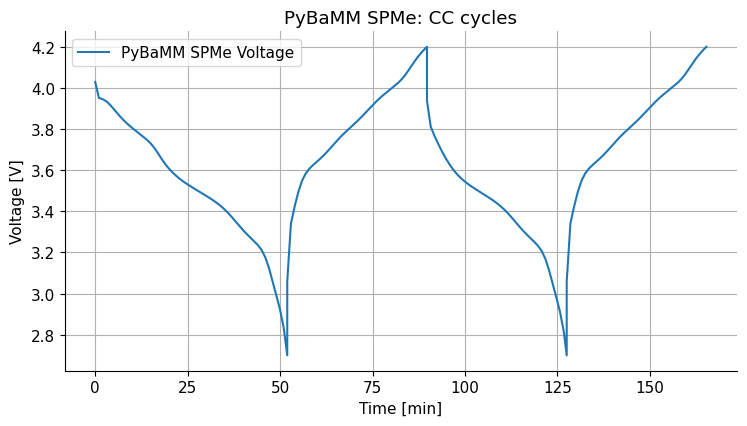

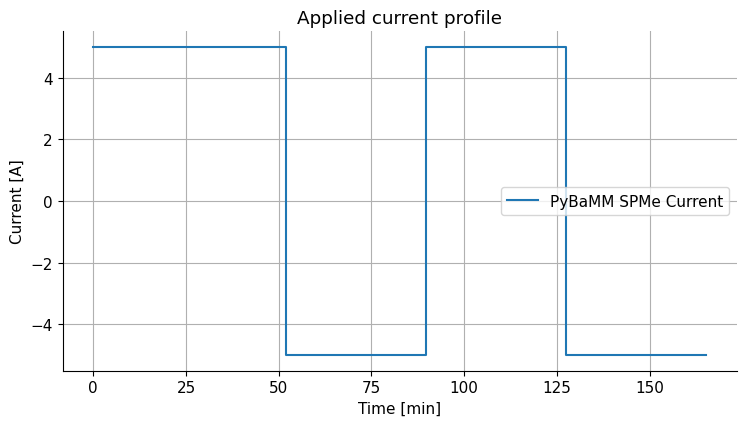

In [3]:
# ----------------------------------------------------- #
# 2) SPMe model: param mapping, experiment, run, plots  #
# ----------------------------------------------------- #

def build_params_from_dict(d: dict) -> pybamm.ParameterValues:
    """
    Map a plain Python parameters dict into `pybamm.ParameterValues` for SPMe.

    The dict `d` uses short names (D1, Kappa, sigmap, ...) and this function
    binds them to the model's expected parameter names, preserving SI units.

    Parameters
    ----------
    d : dict
        Full parameter dictionary including geometry, porosities, transport,
        particle radii, max concentrations, initial stoichiometries, kinetics,
        and experiment/solver scalars.

    Returns
    -------
    pybamm.ParameterValues
        Ready-to-use parameter set for a `pybamm.Simulation`.
    """
    base = pybamm.ParameterValues("Chen2020")

    # Geometry & area
    Ln, Ls, Lp = d["Ln"], d["Ls"], d["Lp"]
    A = d["A"]

    # Initial concentrations from stoichiometries
    c_n0 = d["theta_n0"] * d["csmax_n"]
    c_p0 = d["theta_p0"] * d["csmax_p"]

    updates = {
        # geometry & area
        "Negative electrode thickness [m]": Ln,
        "Separator thickness [m]": Ls,
        "Positive electrode thickness [m]": Lp,
        "Electrode area [m2]": A,

        # porosity
        "Negative electrode porosity": d["eps_e"]["n"],
        "Separator porosity": d["eps_e"]["s"],
        "Positive electrode porosity": d["eps_e"]["p"],

        # electrolyte transport (constant)
        "Electrolyte diffusivity [m2.s-1]": d["D1"],
        "Electrolyte conductivity [S.m-1] (ref)": d["Kappa"],
        "Cation transference number": d["tplus"],

        # solid transport (diffusivity)
        "Negative electrode diffusivity [m2.s-1]": d["Dsn"],
        "Positive electrode diffusivity [m2.s-1]": d["Dsp"],

        # electronic conductivities
        "Negative electrode conductivity [S.m-1]": d["sigman"],
        "Positive electrode conductivity [S.m-1]": d["sigmap"],

        # particle radii
        "Negative particle radius [m]": d["Rp_n"],
        "Positive particle radius [m]": d["Rp_p"],

        # concentrations & initial conditions
        "Maximum concentration in negative electrode [mol.m-3]": d["csmax_n"],
        "Maximum concentration in positive electrode [mol.m-3]": d["csmax_p"],
        "Initial concentration in negative electrode [mol.m-3]": c_n0,
        "Initial concentration in positive electrode [mol.m-3]": c_p0,

        # kinetics (Butler–Volmer)
        "Negative electrode reaction rate constant [m2.5 mol-0.5 s-1]": d["kn"],
        "Positive electrode reaction rate constant [m2.5 mol-0.5 s-1]": d["kp"],

        # temperature (isothermal)
        "Ambient temperature [K]": 298.15,
        "Reference temperature [K]": 298.15,
    }

    base.update(updates, check_already_exists=False)
    return base


def make_experiment(d: dict) -> pybamm.Experiment:
    """
    Create a CC Discharge→Charge PyBaMM experiment, repeated for `n_cycles`.

    Parameters
    ----------
    d : dict
        Must contain: I_cc [A], Vmin [V], Vmax [V], optionally n_cycles.

    Returns
    -------
    pybamm.Experiment
        A simple two-step CC experiment repeated `n_cycles` times.
    """
    I = abs(float(d["I_cc"]))        # A
    Vmin, Vmax = d["Vmin"], d["Vmax"]
    n_cycles = int(d.get("n_cycles", 1))
    steps = [f"Discharge at {I} A until {Vmin} V",
             f"Charge at {I} A until {Vmax} V"] * n_cycles


    # # Optional: add a small rest after each step to help compare plateaus
    # steps = [f"Discharge at {I} A until {Vmin} V", "Rest for 5 seconds",
    #          f"Charge at {I} A until {Vmax} V", "Rest for 5 seconds"] * n_cycles


    return pybamm.Experiment(steps)


def run_spme(d: dict):
    """
    Build and solve the SPMe with parameters in `d`.

    Parameters
    ----------
    d : dict
        Full parameter dictionary (geometry, porosity, transport, kinetics, etc.).

    Returns
    -------
    (sol, sim) : (pybamm.Solution, pybamm.Simulation)
        The solved solution and the simulation object.
    """
    model = pybamm.lithium_ion.SPMe(options={
        "surface form": "algebraic",
        "thermal": "isothermal",
        "SEI": "none",
        "lithium plating": "none",
    })
    param = build_params_from_dict(d)

    # Discretisation controls
    # var_pts = {
    #     "x_n": max(10, d.get("Nx", 80)//6),
    #     "x_s": max(6, d.get("Nx", 80)//10),
    #     "x_p": max(10, d.get("Nx", 80)//6),
    #     "r_n": max(10, d.get("Nr", 20)),
    #     "r_p": max(10, d.get("Nr", 20)),
    # }
    
    var_pts = {
    "x_n": 20,
    "x_s": 15,
    "x_p": 20,
    "r_n": 30,
    "r_p": 30,
    }

    # Experiment
    experiment = make_experiment(d)

    # Solver: use Casadi for speed; set max timestep based on your dt
    dt = float(d.get("dt", 0.05))
    solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-6, dt_max=dt)


    # Simulate
    sim = pybamm.Simulation(model, parameter_values=param, experiment=experiment,
                             var_pts=var_pts, solver=solver)
    sol = sim.solve()

    return sol, sim


def plot_results(sol: pybamm.Solution, label_prefix: str = "PyBaMM SPMe") -> None:
    """
    Quick plots of terminal voltage and current vs time.

    Parameters
    ----------
    sol : pybamm.Solution
        Solution returned by `run_spme`.
    label_prefix : str, optional
        Text prefix used in the legend labels.
    """
    t = sol["Time [s]"].entries
    V = sol["Terminal voltage [V]"].entries
    I = sol["Current [A]"].entries

    plt.figure()
    plt.plot(t/60, V, label=f"{label_prefix} Voltage")
    plt.xlabel("Time [min]"); plt.ylabel("Voltage [V]")
    plt.title("PyBaMM SPMe: CC cycles")
    plt.grid(True); plt.legend(); plt.tight_layout()

    plt.figure()
    plt.plot(t/60, I, label=f"{label_prefix} Current")
    plt.xlabel("Time [min]"); plt.ylabel("Current [A]")
    plt.title("Applied current profile")
    plt.grid(True); plt.legend(); plt.tight_layout()




sol, sim = run_spme(params)
plot_results(sol)
plt.show()


In [4]:
# -------------------------------------------- #
# 3) Bounds, scaling, simulation helper utils  #
# -------------------------------------------- #

 
# From the paper (Matlab implementation)
# %% PSO identificaiton (Input your uppoer and lower bounds for parameters to be identified.)

# pp=0.3;                   % Deviation for upper and lower bounds (percentage)
# D10=1;                    % Electrolyte diffusion coefficient  
# Kappa0=1.17;              % Conductivity
# sigmap0=0.18;             % Solid phase conductivity at positive
# sigman0=215;              % Solid phase conductivity at negative
# Dsp0=4;                   % Solid particle diffusivity at positive
# Dsn0=3.3;                 % Solid particle diffusivity at negative
# kp0=0.7;                  % Reaction rate constant at positive
# kn0=0.7;                  % Reaction rate constant at negative
# Lower_bound = [D10-pp*D10 Kappa0-pp*Kappa0 sigmap0-pp*sigmap0 sigman0-pp*sigman0 Dsp0-pp*Dsp0 Dsn0-pp*Dsn0 kp0-pp*kp0 kn0-pp*kn0];
# Upper_bound = [D10+pp*D10 Kappa0+pp*Kappa0 sigmap0+pp*sigmap0 sigman0+pp*sigman0 Dsp0+pp*Dsp0 Dsn0+pp*Dsn0 kp0+pp*kp0 kn0+pp*kn0]; 

def make_bounds_from_template(template: dict, keys: list[str], pct: float = 0.30):
    """
    Build symmetric physical-space bounds as ±`pct` around template values.
    Example: pct=0.30 →  ±30% around each nominal value.

    Parameters
    ----------
    template : dict
        Nominal dictionary (e.g., paper values) containing all `keys`.
    keys : list[str]
        Parameter names to bound.
    pct : float
        Fractional deviation; 0.30 means ±30%.

    Returns
    -------
    lower : np.ndarray
        Lower bounds (physical units), shape (n_keys,)
    upper : np.ndarray
        Upper bounds (physical units), shape (n_keys,)
    """
    lower = np.array([template[k] * (1 - pct) for k in keys], dtype=float)
    upper = np.array([template[k] * (1 + pct) for k in keys], dtype=float)
    return lower, upper


# def to_unit_space(pd: dict, lower: np.ndarray, upper: np.ndarray, keys=vary_keys) -> np.ndarray:
#     """
#     Map physical dictionary -> unit-space vector x ∈ [0,1]^n via affine scaling:
#     Forward (physical → unit):
#         Rescale each parameter to unit space with an affine map:
#         xi = (P_i - P_i,min) / (P_i,max - P_i,min)  ∈ [0,1]

#     Parameters
#     ----------
#     pd : dict
#         Physical parameters (must contain `keys`).
#     lower, upper : np.ndarray
#         Physical bounds for each parameter.
#     keys : list[str]
#         Parameter names in consistent order.

#     Returns
#     -------
#     x : np.ndarray
#         Unit-space vector.
#     """
#     x = []
#     for k, lo, hi in zip(keys, lower, upper):
#         x.append((pd[k] - lo) / (hi - lo))
#     return np.array(x, dtype=float)


def to_physical_space(template: dict, x_vec: np.ndarray,
                lower: np.ndarray, upper: np.ndarray, keys=vary_keys) -> dict:
    """
    Map unit-space vector x ∈ [0,1]^n -> physical dictionary via:  
    Backward (unit → physical):
        Convert a candidate vector x ∈ [0,1]^8 back to physical values:
        P_i = P_i,min + x_i * (P_i,max - P_i,min)
        Reaction rate constant (negative) 𝑘n(mol/(m²·s))
        Why it helps: the optimizer now works in a balanced box [0,1]^8. Parameters with wildly different magnitudes (e.g., Dsn​ ∼ 10^-14 vs σn ∼ 10^2) 
        no longer skew step sizes and are rescaled to a common range.

    Parameters
    ----------
    template : dict
        Baseline dictionary; all values are copied and only `keys` are updated.
    x_vec : np.ndarray
        Unit-space vector.
    lower, upper : np.ndarray
        Physical bounds for each parameter (same order as `keys`).
    keys : list[str]
        Parameter names in consistent order.

    Returns
    -------
    d : dict
        New dictionary with updated physical parameters.
    """
    d = dict(template)
    for k, xv, lo, hi in zip(keys, x_vec, lower, upper):
        d[k] = float(lo + xv * (hi - lo))
    return d


def simulate_voltage(params_dict: dict):
    """
    Simulate the SPMe and return time, terminal voltage, and current.
    Takes a physical parameter dict, runs your SPMe, and returns arrays for time, voltage, current.

    Parameters
    ----------
    params_dict : dict
        Full set of physical parameters passed to `run_spme`.

    Returns
    -------
    t_sim : np.ndarray
        Time [s]
    V_sim : np.ndarray
        Terminal voltage [V]
    I_sim : np.ndarray
        Current [A]
    """
    sol, _ = run_spme(params_dict)
    t = sol["Time [s]"].entries
    V = sol["Terminal voltage [V]"].entries
    I = sol["Current [A]"].entries
    return t, V, I


def align_to(t_src: np.ndarray, y_src: np.ndarray, t_dst: np.ndarray, fill_value="extrapolate"):
    """

    Notes
    -----
    Even with simulated “measured” data, event cutoffs can shift the solver’s internal time grid.

    Even with the same experiment, different parameter sets can lead the solver
    to take slightly different internal time steps. This keeps the residuals
    comparable on a common time grid (t_dst).
    
    Why alignment is still needed here
    Even though your “measurement” is simulated, the experiment has cutoffs (“until Vmin/Vmax”). 
    Different parameters will reach the cutoff at slightly different times → different time grids/lengths. Without aligning simulated voltage to t_meas, 
    your residual vector shapes won’t match (or you’ll compare mismatched points). Alignment fixes that cleanly.
    """
    f = interp1d(t_src, y_src, kind="linear", bounds_error=False, fill_value=fill_value)
    return f(t_dst)


In [5]:
# ------------------------------------------ #
# 4) Residuals & objective (with caching)    #
# ------------------------------------------ #


def V_error(x_vec: np.ndarray,
                     V_meas: np.ndarray,
                     t_meas: np.ndarray,
                     template_params: dict,
                     lower_phys: np.ndarray,
                     upper_phys: np.ndarray,
                     keys=vary_keys,
                     penalty: float = 1e3) -> np.ndarray:
    """
    Residuals for least_squares in unit space (x ∈ [0,1]^n).

    Parameters
    ----------
    x_vec : np.ndarray
        Unit-space candidate vector.
    t_meas : np.ndarray
        Measurement time stamps [s].
    V_meas : np.ndarray
        Measured terminal voltage [V].
    template_params : dict
        Baseline parameter dictionary to be updated by x_vec.
    lower_phys, upper_phys : np.ndarray
        Physical-space bounds corresponding to x_vec.
    keys : list[str]
        Parameter names (consistent order).
    penalty : float
        Residual magnitude to return if simulation fails.

    Returns
    -------
    residuals : np.ndarray
        (V_meas - V_sim)
    """
    # Map unit → physical
    pd = to_physical_space(template_params, x_vec, lower_phys, upper_phys, keys)
    
    # Run model
    try:
        t_sim, V_sim, _ = simulate_voltage(pd)
    except Exception as e:
        # Penalize failed sims with a big residual shaped like the data
        # (helps the optimizer move away from this region)
        return np.full_like(V_meas, penalty, dtype=float)

    # Align simulated voltage onto the measurement time grid
    if (t_sim.shape != t_meas.shape) or (not np.allclose(t_sim, t_meas)):
        V_sim = align_to(t_sim, V_sim, t_meas)

    return (V_meas - V_sim).astype(float)


def V_objective_scalar(x_vec: np.ndarray,
                       V_meas: np.ndarray,
                       t_meas: np.ndarray,
                       template_params: dict,
                       lower_phys: np.ndarray,
                       upper_phys: np.ndarray,
                       keys=vary_keys) -> float:
    """
    Canonical scalar objective: sum of squares of the voltage residuals.

    This is the recommended objective for PSO/DE/global search. Least-squares
    directly uses the residual vector `V_error` for a more efficient solve.

    Returns
    -------
    float
        Sum of squared residuals.
    """
    res = V_error(
        x_vec=x_vec,
        V_meas=V_meas,
        t_meas=t_meas,
        template_params=template_params,
        lower_phys=lower_phys,
        upper_phys=upper_phys,
        keys=keys,
        penalty=1e3,  # keep big so failed sims are strongly discouraged
    )
    # L2^2 keeps the scale additive across points
    return float(np.dot(res, res))

# ------------------------------ #
# ---- Optional caching wrapper (disabled unless you pass use_cache=True) ----
def _quantize(x: np.ndarray, ndp: int = 6) -> tuple:
    """
    Round a vector to `ndp` decimals and return a tuple (cache key).

    Rounding clusters near-duplicate points so they hit the cache.
    """
    return tuple(np.round(np.asarray(x, float), ndp))


@lru_cache(maxsize=2048)
def _objective_cached(qx: tuple, V_meas_key: int, t_meas_key: int,
                      template_params_key: int, lower_key: int, upper_key: int, keys_key: int) -> float:
    """
    Cached objective backend. The *_key integers allow you to invalidate
    the cache when swapping datasets without hashing large arrays.

    Notes
    -----
    This function relies on module-level globals set by the user.
    """
    x_vec = np.array(qx, dtype=float)
    return V_objective_scalar(x_vec, _GLOBAL_V_MEAS, _GLOBAL_T_MEAS,
                              _GLOBAL_TEMPLATE, _GLOBAL_LOWER, _GLOBAL_UPPER, _GLOBAL_KEYS)


def V_objective_scalar_cached(x_vec: np.ndarray) -> float:
    """
    Cached wrapper for the scalar objective. Enable by passing `use_cache=True`
    to PSO/DE. Make sure to set the module-level globals beforehand.
    """
    return _objective_cached(_quantize(x_vec), 0, 0, 0, 0, 0, 0)


def clear_objective_cache() -> None:
    """
    Clear the LRU cache used by `V_objective_scalar_cached`.

    Call this after changing `t_meas`, `V_meas`, bounds, or the base params.
    """
    _objective_cached.cache_clear()

#------------------------------- #

In [6]:
# ------------------------------- #
# 5) Optimizers: LS, PSO, and DE  #
# ------------------------------- #

def compute_param_errors(est: dict, truth: dict, keys=vary_keys):
    """
    Compute absolute and relative errors for each parameter in `keys`.

    Parameters
    ----------
    est : dict
        Estimated parameters.
    truth : dict
        Ground truth (or nominal) parameters to compare with.
    keys : list[str]
        Ordered parameter names to evaluate.

    Returns
    -------
    (abs_err, rel_err) : (dict, dict)
        Dicts keyed by parameter name.
    """
    tiny = 1e-30
    abs_err = {k: abs(est[k] - truth[k]) for k in keys}
    rel_err = {k: abs(est[k] - truth[k]) / max(abs(truth[k]), tiny) for k in keys}
    return abs_err, rel_err

def run_least_squares(t_meas: np.ndarray,
                      V_meas: np.ndarray,
                      template_params: dict,
                      lower_phys: np.ndarray,
                      upper_phys: np.ndarray,
                      keys=vary_keys,
                      n_starts: int = 5,
                      seed: int | None = 0,
                      max_nfev: int = 80,
                      tol: float = 1e-9,
                      truth_for_eval: dict | None = None):
    """
    Multi-start bounded least-squares in unit space using `scipy.optimize.least_squares`.

    Each start samples a random x0 ∈ [0,1]^n and solves using the residual
    vector from `V_error`. Returns the best run plus a per-start log.

    Parameters
    ----------
    t_meas, V_meas : np.ndarray
        Measurement time grid and voltage samples.
    template_params : dict
        Baseline physical parameter dictionary updated by x during solves.
    lower_phys, upper_phys : np.ndarray
        Physical-space bounds arrays for `keys`.
    keys : list[str], optional
        Parameter names (length n).
    n_starts : int, optional
        Number of random initializations.
    seed : int | None, optional
        RNG seed for repeatability; set None for non-deterministic starts.
    max_nfev : int, optional
        Function evaluation cap per start.
    tol : float, optional
        Termination tolerances (ftol, xtol, gtol).
    truth_for_eval : dict | None, optional
        If provided, error metrics vs truth are recorded per run.

    Returns
    -------
    (best_est_params, best_result, runs) : (dict, OptimizeResult, list[dict])
        The best physical-parameter dict, the SciPy result, and the per-start log.
    """
    rng = np.random.default_rng(seed)
    bounds_unit = (np.zeros(len(keys)), np.ones(len(keys)))

    best = None
    runs = []

    for i in range(n_starts):
        x0 = rng.uniform(0.0, 1.0, size=len(keys))
        res = least_squares(
            V_error, x0,
            bounds=bounds_unit,
            args=(V_meas, t_meas, template_params, lower_phys, upper_phys, keys),
            method="trf",
            loss="linear",
            ftol=tol, xtol=tol, gtol=tol,
            max_nfev=max_nfev,
        )
        normr = float(np.linalg.norm(res.fun))
        xhat = res.x
        est_params = to_physical_space(template_params, xhat, lower_phys, upper_phys, keys)

        rec = {
            "start": i + 1,
            "x0_unit": x0,
            "xhat_unit": xhat,
            "residual_norm_2": normr,
            "status": int(res.status),
            "est_params": {k: float(est_params[k]) for k in keys},
        }
        if truth_for_eval is not None:
            abs_err, rel_err = compute_param_errors(est_params, truth_for_eval, keys)
            rec["abs_err"] = {k: float(abs_err[k]) for k in keys}
            rec["rel_err"] = {k: float(rel_err[k]) for k in keys}

        runs.append(rec)
        print(f"[start {i+1}/{n_starts}] ||res||_2={normr:.6g} status={res.status}")

        if (best is None) or (normr < np.linalg.norm(best.fun)):
            best = res

    best_est_params = to_physical_space(template_params, best.x, lower_phys, upper_phys, keys)
    return best_est_params, best, runs

def print_runs_summary(runs, keys=vary_keys, truth=None):
    """
    Console-friendly summary of multi-start LS runs (with optional rel. errors).

    Parameters
    ----------
    runs : list[dict]
        Per-start records returned by `run_least_squares`.
    keys : list[str]
        Parameter names for column order.
    truth : dict | None
        If provided, relative errors are printed per parameter.
    """
    print("\n=== Multi-start summary ===")
    header = ["start", "||res||_2"] + [f"est_{k}" for k in keys]
    if truth is not None:
        header += [f"rel_err_{k}" for k in keys]
    print(" | ".join(f"{h:>14s}" for h in header))
    for r in runs:
        row = [f"{r['start']:>14d}", f"{r['residual_norm_2']:>14.6g}"]
        row += [f"{r['est_params'][k]:>14.6g}" for k in keys]
        if truth is not None and "rel_err" in r:
            row += [f"{r['rel_err'][k]:>14.3e}" for k in keys]
        print(" | ".join(row))
        

# --- PSO (PySwarms) ---
def fit_pso(t_meas: np.ndarray,
            V_meas: np.ndarray,
            template_params: dict,
            lower_phys: np.ndarray,
            upper_phys: np.ndarray,
            keys=vary_keys,
            swarm_size: int = 24,
            iters: int = 60,
            seed: int | None = 0,
            options: dict | None = None,
            use_cache: bool = False):
    """
    GlobalBest Particle Swarm Optimization over x ∈ [0,1]^n.

    Parameters
    ----------
    t_meas, V_meas, template_params, lower_phys, upper_phys, keys
        See `run_least_squares`.
    swarm_size : int, optional
        Number of particles.
    iters : int, optional
        Iterations of the swarm.
    seed : int | None, optional
        RNG seed for reproducibility. Set None for random.
    options : dict | None, optional
        PySwarms options: {c1, c2, w, ftol, ftol_iter}.
    use_cache : bool, optional
        If True, uses `V_objective_scalar_cached` to accelerate repeats.

    Returns
    -------
    (best_est_params, best_cost, best_x, history)
        Physical-parameter dict, best objective value, best unit vector,
        and per-iteration best-cost history.
    """
    from pyswarms.single.global_best import GlobalBestPSO

    n_dim = len(keys)
    lb = np.zeros(n_dim); ub = np.ones(n_dim)
    bounds = (lb, ub)

    if seed is not None:
        np.random.seed(seed)

    if options is None:
        options = {"c1": 1.6, "c2": 1.6, "w": 0.6, "ftol": 1e-8, "ftol_iter": 8}

    def cost_matrix(X: np.ndarray) -> np.ndarray:
        costs = np.empty(X.shape[0], dtype=float)
        for i, xi in enumerate(X):
            if use_cache:
                costs[i] = V_objective_scalar_cached(xi)
            else:
                costs[i] = V_objective_scalar(xi, V_meas, t_meas, template_params, lower_phys, upper_phys, keys)
        return costs

    optimizer = GlobalBestPSO(n_particles=swarm_size, dimensions=n_dim, options=options, bounds=bounds)
    best_cost, best_x = optimizer.optimize(cost_matrix, iters=iters, verbose=True)

    best_est_params = to_physical_space(template_params, best_x, lower_phys, upper_phys, keys)
    history = list(optimizer.cost_history)  # per-iteration best cost
    return best_est_params, float(best_cost), best_x, history


# --- Differential Evolution (SciPy) ---
def fit_de(t_meas: np.ndarray,
           V_meas: np.ndarray,
           template_params: dict,
           lower_phys: np.ndarray,
           upper_phys: np.ndarray,
           keys=vary_keys,
           maxiter: int = 60,
           popsize: int = 18,
           seed: int | None = 0,
           strategy: str = "best1bin",
           mutation=(0.5, 1.0),
           recombination: float = 0.7,
           polish: bool = False,
           workers: int = 1,
           use_cache: bool = False):
    """
    Differential Evolution (SciPy) over x ∈ [0,1]^n with per-iteration history.

    Parameters
    ----------
    (t_meas, V_meas, template_params, lower_phys, upper_phys, keys)
        See `run_least_squares`.
    maxiter, popsize, strategy, mutation, recombination, polish, workers
        Passed through to `scipy.optimize.differential_evolution`.
    use_cache : bool, optional
        If True, uses the cached objective (single-process only).

    Returns
    -------
    (best_est_params, best_cost, best_x, history)
        Physical-parameter dict, best objective value, best unit vector,
        and list of best costs per iteration (via callback).
    """
    n_dim = len(keys)
    bounds = [(0.0, 1.0)] * n_dim
    history: list[float] = []

    def cost(x: np.ndarray) -> float:
        if use_cache:
            return V_objective_scalar_cached(x)
        return V_objective_scalar(x, V_meas, t_meas, template_params, lower_phys, upper_phys, keys)

    def _cb(xk, convergence):
        # Record current best cost each iteration (cheap compared to population evals)
        try:
            history.append(cost(xk))
        except Exception:
            history.append(np.nan)
        return False  # continue

    res = differential_evolution(
        cost, bounds=bounds, strategy=strategy, maxiter=maxiter, popsize=popsize,
        tol=1e-8, mutation=mutation, recombination=recombination, seed=seed,
        polish=polish, updating="deferred" if workers != 1 else "immediate",
        workers=workers, disp=True, callback=_cb,
    )
    best_x = res.x
    best_cost = float(res.fun)
    best_est_params = to_physical_space(template_params, best_x, lower_phys, upper_phys, keys)
    return best_est_params, best_cost, best_x, history



In [7]:
# ----------------------------------------- #
# 6) Plot helpers: overlays & convergence   #
# ----------------------------------------- #
def _overlay_fit(label: str, est_params: dict,
                 t_meas: np.ndarray, V_meas: np.ndarray) -> None:
    """
    Simulate `est_params` and plot V(t) over the measurement reference.
    """
    t_fit, V_fit, _ = simulate_voltage(est_params)
    if (t_fit.shape != t_meas.shape) or (not np.allclose(t_fit, t_meas)):
        V_fit = align_to(t_fit, V_fit, t_meas)
    plt.plot(t_meas / 60, V_fit, "--", label=label)


def _plot_history(hist: list[float], title: str) -> None:
    """
    Plot per-iteration best cost history if available.
    """
    if hist and len(hist) > 0:
        plt.figure()
        plt.plot(np.arange(1, len(hist) + 1), hist)
        plt.xlabel("Iteration")
        plt.ylabel("Best cost (sum of squares)")
        plt.title(title)
        plt.tight_layout()
        plt.show()


In [8]:
# -------------------------------- #
# 7) Bounds, globals for cache     #
# -------------------------------- #

# Bounds (±30%) in physical space
lower_phys, upper_phys = make_bounds_from_template(params, vary_keys, pct=0.30)

# “Measured” curve = simulation of the nominal params (no noise)
t_meas, V_meas, _ = simulate_voltage(params)

# Optional: enable cache globals (only used if use_cache=True for PSO/DE)
_GLOBAL_V_MEAS = V_meas
_GLOBAL_T_MEAS = t_meas
_GLOBAL_TEMPLATE = params
_GLOBAL_LOWER = lower_phys
_GLOBAL_UPPER = upper_phys
_GLOBAL_KEYS = tuple(vary_keys)

print("Configuration ready.")



Configuration ready.


[start 1/50] ||res||_2=1.4537 status=3
[start 2/50] ||res||_2=0.901129 status=3
[start 3/50] ||res||_2=1.51696 status=3
[start 4/50] ||res||_2=1.24229 status=3
[start 5/50] ||res||_2=1.2321 status=3
[start 6/50] ||res||_2=1.82627 status=3
[start 7/50] ||res||_2=2.2906 status=3
[start 8/50] ||res||_2=0.556987 status=3
[start 9/50] ||res||_2=1.23994 status=3
[start 10/50] ||res||_2=0.597513 status=3
[start 11/50] ||res||_2=0.742188 status=3
[start 12/50] ||res||_2=0.594361 status=3
[start 13/50] ||res||_2=0.617435 status=3
[start 14/50] ||res||_2=0.606891 status=3
[start 15/50] ||res||_2=0.565964 status=3
[start 16/50] ||res||_2=1.84895 status=3
[start 17/50] ||res||_2=1.6161 status=3
[start 18/50] ||res||_2=0.673622 status=3
[start 19/50] ||res||_2=2.15621 status=3
[start 20/50] ||res||_2=0.835826 status=3
[start 21/50] ||res||_2=1.71587 status=3
[start 22/50] ||res||_2=0.891737 status=3
[start 23/50] ||res||_2=0.624186 status=3
[start 24/50] ||res||_2=0.89758 status=3
[start 25/50] ||r

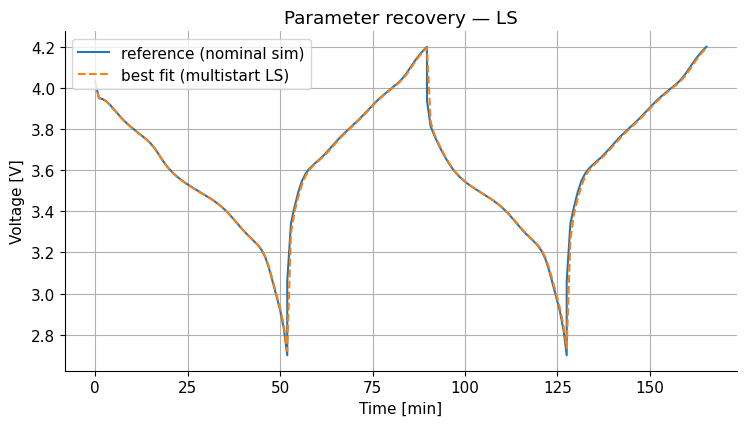

In [9]:
# -------------------------------------- #
# 8) Least-squares demo & visualization  #
# -------------------------------------- #
est_params_ls, res_ls, runs_ls = run_least_squares(
    t_meas=t_meas,
    V_meas=V_meas,
    template_params=params,
    lower_phys=lower_phys,
    upper_phys=upper_phys,
    keys=vary_keys,
    n_starts=50,
    seed=123,
    max_nfev=80,
    tol=1e-9,
    truth_for_eval=params,
)
print_runs_summary(runs_ls, keys=vary_keys, truth=params)

# LS overlay
t_fit, V_fit, _ = simulate_voltage(est_params_ls)
if (t_fit.shape != t_meas.shape) or (not np.allclose(t_fit, t_meas)):
    V_fit = align_to(t_fit, V_fit, t_meas)

print("\nBest-fit vs nominal (LS):")
for k in vary_keys:
    rel_err = abs(est_params_ls[k] - params[k]) / max(abs(params[k]), 1e-30)
    print(f"  {k:7s}: est={est_params_ls[k]:.6g}, nominal={params[k]:.6g}, rel_err={rel_err:.3e}")
print(f"\n[LS] ||residual||_2 = {np.linalg.norm(res_ls.fun):.6g}, status: {res_ls.status}")

plt.figure()
plt.plot(t_meas / 60, V_meas, label="reference (nominal sim)")
plt.plot(t_meas / 60, V_fit, "--", label="best fit (multistart LS)")
plt.xlabel("Time [min]")
plt.ylabel("Voltage [V]")
plt.title("Parameter recovery — LS")
plt.legend()
plt.tight_layout()
plt.show()


2025-08-29 05:21:27,626 - pyswarms.single.global_best - INFO - Optimize for 40 iters with {'c1': 1.6, 'c2': 1.6, 'w': 0.6, 'ftol': 1e-08, 'ftol_iter': 8}
pyswarms.single.global_best: 100%|██████████|40/40, best_cost=0.303
2025-08-29 06:11:20,352 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.30321524049398507, best pos: [0.39843423 0.511698   0.00675419 0.11720718 0.51430626 0.91001607
 0.65834785 0.51499163]



[PSO] best cost (sum of squares): 0.30321524049398507


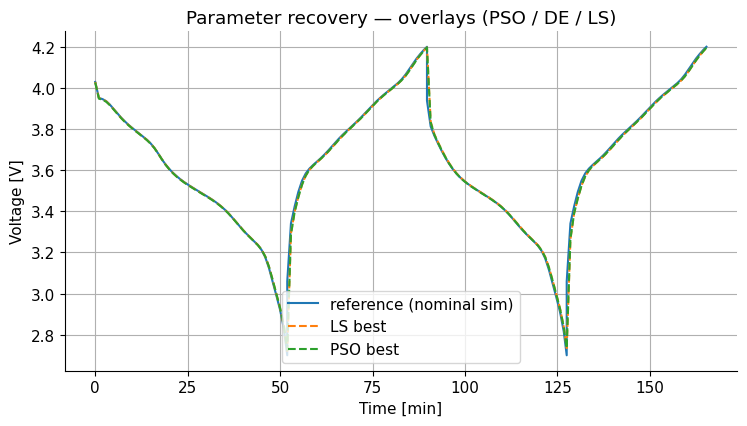

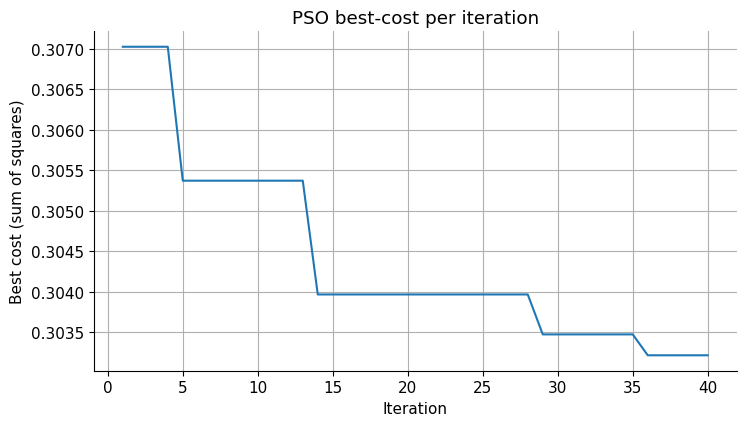

In [10]:
# -------------------------------------- #
# 9) Optional PSO / DE runs + overlays   #
# -------------------------------------- #
RUN_PSO = True   # flip True to run (requires pyswarms)
RUN_DE  = False   # flip True to run

if RUN_PSO:
    pso_est, pso_cost, pso_x, pso_hist = fit_pso(
        t_meas, V_meas, params, lower_phys, upper_phys,
        keys=vary_keys, swarm_size=24, iters=40, seed=123, use_cache=True
    )
    print("\n[PSO] best cost (sum of squares):", pso_cost)

if RUN_DE:
    de_est, de_cost, de_x, de_hist = fit_de(
        t_meas, V_meas, params, lower_phys, upper_phys,
        keys=vary_keys, maxiter=40, popsize=14, seed=123, workers=1, use_cache=True
    )
    print("\n[DE] best cost (sum of squares):", de_cost)

# Combined overlays if PSO/DE ran
if RUN_PSO or RUN_DE:
    plt.figure()
    plt.plot(t_meas / 60, V_meas, label="reference (nominal sim)")
    _overlay_fit("LS best", est_params_ls, t_meas, V_meas)
    if RUN_PSO and "pso_est" in globals():
        _overlay_fit("PSO best", pso_est, t_meas, V_meas)
    if RUN_DE and "de_est" in globals():
        _overlay_fit("DE best", de_est, t_meas, V_meas)
    plt.xlabel("Time [min]")
    plt.ylabel("Voltage [V]")
    plt.title("Parameter recovery — overlays (PSO / DE / LS)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Convergence plots
if RUN_PSO and "pso_hist" in globals():
    _plot_history(pso_hist, "PSO best-cost per iteration")
if RUN_DE and "de_hist" in globals():
    _plot_history(de_hist, "DE best-cost per iteration")

### Cache maintenance
Run this cell if you change **data**, **bounds**, or **nominal parameters**.

In [11]:
# --- Final cleanup: clear any cached objective evaluations ---
try:
    clear_objective_cache()
    print("Objective cache cleared.")
except NameError:
    print("No clear_objective_cache() found; skipping.")

Objective cache cleared.


In [9]:
# def V_error(params_vec,y_meas):
#     # handle parameters 
#     # handle the dict to be in array format
#     # Can we recover the optimal parameters
#     # xo initial guess
#     # errors goes to zero and does it go to the true parameters
#     sol, sim = run_spme(params)
#     y_sim = sol["Terminal voltage [V]"].entries
    
#     return y_meas - y_sim

